# README – Energy Time Series Forecasting

Ce notebook présente une approche complète de prévision de la consommation d’énergie pour un business group à Alesund, à partir de données historiques. Il couvre toutes les étapes du workflow de data science, de l’importation des données à l’évaluation du modèle.

## Structure du notebook
 **Import des bibliothèques**  
    Chargement des librairies nécessaires pour la manipulation des données, la visualisation, le prétraitement et le deep learning (TensorFlow/Keras).

 **Chargement et préparation des données**  
    - Importation du jeu de données.
    - Transformation des variables (création de la variable cible, suppression de colonnes inutiles).
    - Feature engineering (extraction de composantes temporelles, encodage cyclique).

 **Prétraitement**  
    - Visualisation des distributions.
    - Normalisation des variables (MinMaxScaler pour les variables asymétriques, StandardScaler pour les variables normales).

 **Construction des séquences temporelles**  
    Création de fenêtres glissantes pour préparer les données à l’entrée d’un modèle LSTM.

 **Modélisation LSTM**  
    - Construction d’un modèle séquentiel avec deux couches LSTM et une couche Dense.
    - Compilation et entraînement du modèle.

 **Évaluation et visualisation**  
    - Prédiction sur le jeu de test.
    - Inversion de la normalisation pour interpréter les résultats.
    - Calcul et visualisation de la MAPE (Mean Absolute Percentage Error) globale et par tranche.
    - Analyse des erreurs selon les mois, jours et jours de la semaine.

## Points forts

- **Prétraitement avancé** : Encodage cyclique des variables temporelles, normalisation adaptée à chaque type de variable.
- **Modélisation séquentielle** : Utilisation d’un LSTM pour capturer la dynamique temporelle.
- **Évaluation détaillée** : Analyse fine des erreurs selon différentes dimensions temporelles.

## Utilisation

1. Placez le fichier de données `business_group_data.csv` dans le même dossier que le notebook.
2. Exécutez chaque cellule dans l’ordre pour reproduire l’analyse et la modélisation.
3. Adaptez les paramètres (par exemple, la taille des séquences ou l’architecture du modèle) selon vos besoins.

## Prérequis

- Python 3.x
- Bibliothèques : pandas, numpy, matplotlib, seaborn, scikit-learn, tensorflow

---

*Auteur : Mghyly Oumaima*  
*Date : 28/07/2025*

## Introduction

Prédiction de la consommation d’énergie du business groupe dans Alesund à partir des données historiques.

## Import des bibliothèques

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   # For visualizations
from sklearn.preprocessing import MinMaxScaler  # For scaling features
from sklearn.preprocessing import StandardScaler   # For scaling features
import seaborn as sns  # For visualizations
import tensorflow as tf  # Import TensorFlow for LSTM
from tensorflow.keras.models import Sequential   # Sequential model for LSTM
from tensorflow.keras.layers import LSTM, Dense  # LSTM layer for time series
from tensorflow.keras.metrics import MeanAbsolutePercentageError   # For MAPE calculation
from tensorflow.keras.callbacks import ReduceLROnPlateau     # For learning rate reduction
from tensorflow.keras.optimizers import Adam   # Ensure reproducibility
from sklearn.metrics import mean_absolute_percentage_error
import random    # This import is used for random seed setting

## Chargement des données 

In [164]:
df_business_consumption=pd.read_csv('business_group_data.csv')  # Load the dataset

In [165]:
df_business_consumption['Date'] = pd.to_datetime(
    df_business_consumption['Date'])   # Convert 'Date' column to datetime format

In [166]:
# Création de la nouvelle colonne
df_business_consumption["Consommation"] = df_business_consumption["VOLUME_KWH"] / df_business_consumption["METERINGPOINT_COUNT"]

# Suppression des deux colonnes d'origine
df_business_consumption.drop(columns=["VOLUME_KWH", "METERINGPOINT_COUNT"], inplace=True)


## Feature engineering

In [167]:

# Extraire les composants de date
df_business_consumption['hour'] = df_business_consumption['Date'].dt.hour
df_business_consumption['month'] = df_business_consumption['Date'].dt.month
df_business_consumption['weekday'] = df_business_consumption['Date'].dt.weekday  # 0 = lundi, 6 = dimanche
df_business_consumption['dayofyear'] = df_business_consumption['Date'].dt.dayofyear

# Vérification
df_business_consumption.head()


,Date,wind_speed,t2m_C,surface_pressure,Consommation,hour,month,weekday,dayofyear
0,2021-01-01 00:00:00,2.798005,1.68923,98874.560,8.082154,0,1,4,1
1,2021-01-01 01:00:00,2.630726,1.32168,98905.060,8.021209,1,1,4,1
2,2021-01-01 02:00:00,2.387332,1.01553,98930.625,8.132821,2,1,4,1
3,2021-01-01 03:00:00,1.984651,0.77847,98928.000,8.151846,3,1,4,1
4,2021-01-01 04:00:00,1.515596,0.66543,98949.560,8.389451,4,1,4,1


In [168]:
df_business_consumption.drop(columns=["wind_speed"], inplace=True)   # Drop the 'wind_speed' column 

##  Prétraitement des données

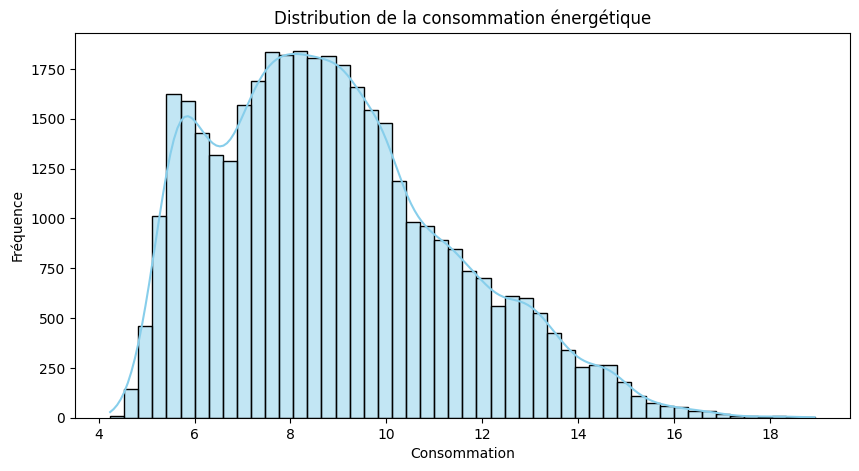

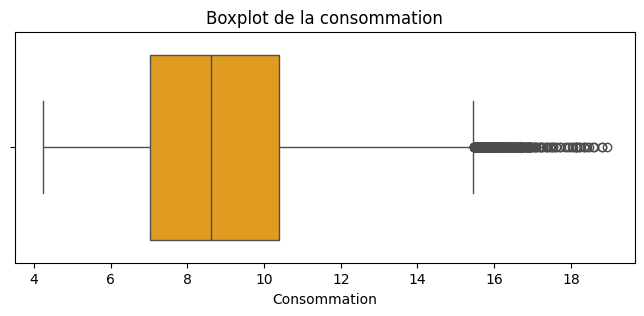

In [169]:

# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["Consommation"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la consommation énergétique")
plt.xlabel("Consommation")
plt.ylabel("Fréquence")
plt.show()

# Boxplot (pour voir les outliers)
plt.figure(figsize=(8, 3))
sns.boxplot(x=df_business_consumption["Consommation"], color="orange")
plt.title("Boxplot de la consommation")
plt.show()


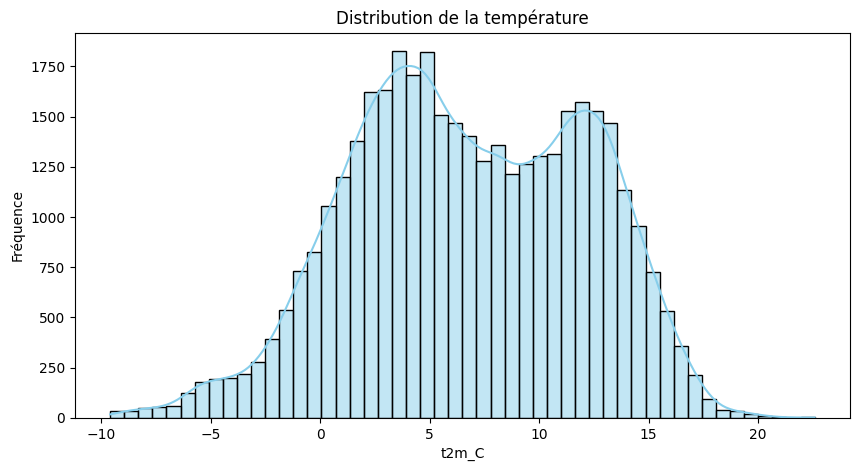

In [170]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["t2m_C"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la température")
plt.xlabel("t2m_C")
plt.ylabel("Fréquence")
plt.show()

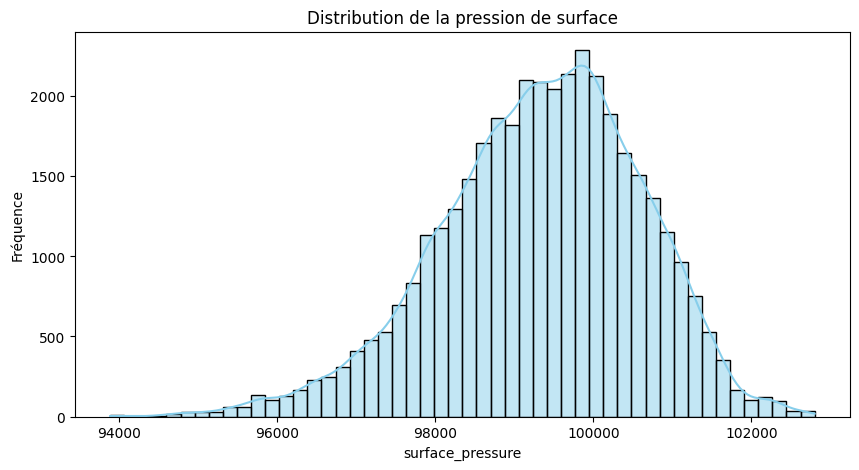

In [171]:
# Histogramme
plt.figure(figsize=(10, 5))
sns.histplot(df_business_consumption["surface_pressure"], bins=50, kde=True, color="skyblue")
plt.title("Distribution de la pression de surface")
plt.xlabel("surface_pressure")
plt.ylabel("Fréquence")
plt.show()

MinMaxScaler  il est plus adapté aux données asymétriques.

In [172]:

df_normalise=df_business_consumption.copy()  # Créer une copie du DataFrame pour la normalisation
# Liste des colonnes à normaliser
colonnes_a_normaliser = ["Consommation" , "t2m_C"]
scalers_minmax = {} # Dictionnaire pour stocker les scalers MinMax pour chaque colonne
for col in colonnes_a_normaliser:       # Normalisation Min-Max
    scaler = MinMaxScaler()
    df_normalise[col] = scaler.fit_transform(df_normalise[[col]])   # Fit and transform the column
    scalers_minmax[col] = scaler


StandardScaler pour la distribution normale
La normalisation standard transforme chaque valeur \( x \) selon la formule :

$$ 
z = \frac{x - \mu}{\sigma}
$$ 

où :

- `x` : la valeur brute  
- `μ` : la moyenne de toutes les valeurs  
- `σ` : l’écart type 

Le StandardScaler ne limite pas les valeurs à un intervalle fixe comme [0, 1]. Contrairement à MinMaxScaler, qui écrase tout entre deux bornes, StandardScaler transforme les données pour qu’elles aient :

    une moyenne = 0

    un écart-type = 1

In [173]:
colonnes_standard = ["surface_pressure"]  # Liste des colonnes à standardiser
scalers_standard = {}   # Dictionnaire pour stocker les scalers Standard pour chaque colonne
for col in colonnes_standard:
    scaler = StandardScaler()    # Standardisation
    df_normalise[col] = scaler.fit_transform(df_normalise[[col]])
    scalers_standard[col] = scaler  # Store the scaler for later use


In [174]:
# Encodage cyclique
df_normalise["hour_sin"] = np.sin(2 * np.pi * df_normalise["hour"] / 24)   # Encode hour as sine wave
df_normalise["hour_cos"] = np.cos(2 * np.pi * df_normalise["hour"] / 24)

df_normalise["month_sin"] = np.sin(2 * np.pi * df_normalise["month"] / 12)
df_normalise["month_cos"] = np.cos(2 * np.pi * df_normalise["month"] / 12)

df_normalise["weekday_sin"] = np.sin(2 * np.pi * df_normalise["weekday"] / 7)
df_normalise["weekday_cos"] = np.cos(2 * np.pi * df_normalise["weekday"] / 7)

df_normalise["dayofyear_sin"] = np.sin(2 * np.pi * df_normalise["dayofyear"] / 365)
df_normalise["dayofyear_cos"] = np.cos(2 * np.pi * df_normalise["dayofyear"] / 365)

In [175]:
df_normalise

,Date,t2m_C,surface_pressure,Consommation,hour,month,weekday,dayofyear,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
0,2021-01-01 00:00:00,0.350590,-0.356407,0.261538,0,1,4,1,0.000000e+00,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
1,2021-01-01 01:00:00,0.339167,-0.332534,0.257389,1,1,4,1,2.588190e-01,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2,2021-01-01 02:00:00,0.329652,-0.312523,0.264986,2,1,4,1,5.000000e-01,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
3,2021-01-01 03:00:00,0.322284,-0.314578,0.266281,3,1,4,1,7.071068e-01,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
4,2021-01-01 04:00:00,0.318771,-0.297702,0.282455,4,1,4,1,8.660254e-01,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38457,2025-05-22 09:00:00,0.508829,0.384255,0.560058,9,5,3,142,7.071068e-01,-0.707107,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38458,2025-05-22 10:00:00,0.506474,0.390666,0.550630,10,5,3,142,5.000000e-01,-0.866025,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38459,2025-05-22 11:00:00,0.517676,0.405585,0.543712,11,5,3,142,2.588190e-01,-0.965926,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659
38460,2025-05-22 12:00:00,0.524023,0.414782,0.522251,12,5,3,142,1.224647e-16,-1.000000,0.5,-0.866025,0.433884,-0.900969,0.642055,-0.766659


In [176]:
df_normalise.index=df_normalise['Date']  # Set 'Date' as index for time series analysis

df_normalise.drop(columns=["Date","hour", "month", "weekday", "dayofyear"], inplace=True)  # Drop original date and time columns

df_normalise.head()

,t2m_C,surface_pressure,Consommation,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,,
2021-01-01 00:00:00,0.350590,-0.356407,0.261538,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,0.339167,-0.332534,0.257389,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,0.329652,-0.312523,0.264986,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,0.322284,-0.314578,0.266281,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,0.318771,-0.297702,0.282455,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852


In [177]:
col = 'Consommation'
# Réorganiser les colonnes
df_normalise = df_normalise[[col] + [c for c in df_normalise.columns if c != col]]  # Réorganiser les colonnes pour que 'Consommation' soit en première position

In [178]:
df_normalise.head()

,Consommation,t2m_C,surface_pressure,hour_sin,hour_cos,month_sin,month_cos,weekday_sin,weekday_cos,dayofyear_sin,dayofyear_cos
Date,,,,,,,,,,,
2021-01-01 00:00:00,0.261538,0.350590,-0.356407,0.000000,1.000000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 01:00:00,0.257389,0.339167,-0.332534,0.258819,0.965926,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 02:00:00,0.264986,0.329652,-0.312523,0.500000,0.866025,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 03:00:00,0.266281,0.322284,-0.314578,0.707107,0.707107,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852
2021-01-01 04:00:00,0.282455,0.318771,-0.297702,0.866025,0.500000,0.5,0.866025,-0.433884,-0.900969,0.017213,0.999852


## @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

## prediction

Construction des séquences
Créer des fenêtres de 24 heures (séquences) pour prédire les 24 heures suivantes.

In [179]:
df_normalise1 = df_normalise.copy()  # Créer une copie du DataFrame pour la normalisation
sequence_length = 24  # Nombre de pas de temps dans chaque séquence
forecast_horizon = 24 # Nombre de pas de temps à prédire

def create_sequences(data, target_col, sequence_length, forecast_horizon):    # Fonction pour créer des séquences de données
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):  # Ensure we have enough data for sequences
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length:i+sequence_length+forecast_horizon][target_col].values)   # Append the target values for the forecast horizon
    return np.array(X), np.array(y)


target_col = "Consommation"

X, y = create_sequences(df_normalise1, target_col, sequence_length, forecast_horizon)      


In [180]:
print(X[0].shape)
print(len(X))

(24, 11)
38414


In [181]:
print(y[0].shape)
print(len(y))

(24,)
38414


Séparation et entraînement

In [182]:
split_idx = int(0.8 * len(X))  # Split the data into training and testing sets
X_train1, X_test1 = X[:split_idx], X[split_idx:]   
y_train1, y_test1 = y[:split_idx], y[split_idx:]


In [183]:

X_test_indices = [i for i in range(len(df_normalise1) - sequence_length - forecast_horizon)][-len(X_test1):]   # Get the indices of the test set sequences

Modèle LSTM

un modèle séquentiel --> chaque couche est empilée l’une après l’autre.

64 nombre de cellules (ou neurones) dans la LSTM



La MAPE mesure l'erreur relative moyenne entre les valeurs réelles et prédites, exprimée en pourcentage.
$$
\text{MAPE} = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|
$$



In [184]:


model1 = Sequential([
    LSTM(64,  return_sequences=True, dropout=0.1, recurrent_dropout=0.1, input_shape=(sequence_length, X.shape[2])),  # 1re couche LSTM
    LSTM(32, dropout=0.1, recurrent_dropout=0.1,  return_sequences=False),  # 2e couche LSTM
    
    Dense(forecast_horizon, activation='linear')  # 24 sorties pour les 24 heures futures
])

model1.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[MeanAbsolutePercentageError()])   # Compile the model with MSE loss and MAPE metric


model1.summary()

c:\Users\emac\OneDrive - IMT Mines Albi\Projet stage\Eneenergy-forecasting-1\project_venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 24, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,664 (127.59 KB)

 Trainable params: 32,664 (127.59 KB)

 Non-trainable params: 0 (0.00 B)

In [185]:
history = model1.fit(X_train1, y_train1, epochs=40, batch_size=30,  validation_data=(X_test1, y_test1),
verbose=1)    # Training the model with validation data 


Epoch 1/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0578 - mean_absolute_percentage_error: 64.2296 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 14380.0391
Epoch 2/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0089 - mean_absolute_percentage_error: 31.5608 - val_loss: 0.0058 - val_mean_absolute_percentage_error: 13166.9834
Epoch 3/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 30s 29ms/step - loss: 0.0067 - mean_absolute_percentage_error: 26.8708 - val_loss: 0.0049 - val_mean_absolute_percentage_error: 13029.9355
Epoch 4/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 36s 35ms/step - loss: 0.0058 - mean_absolute_percentage_error: 24.6310 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 11639.7939
Epoch 5/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - loss: 0.0050 - mean_absolute_percentage_error: 22.6372 - val_loss: 0.0041 - val_mean_absolute_percentage_error: 11195.8760
Epoch 6/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - loss: 0.0045 - mean_absolute_percenta

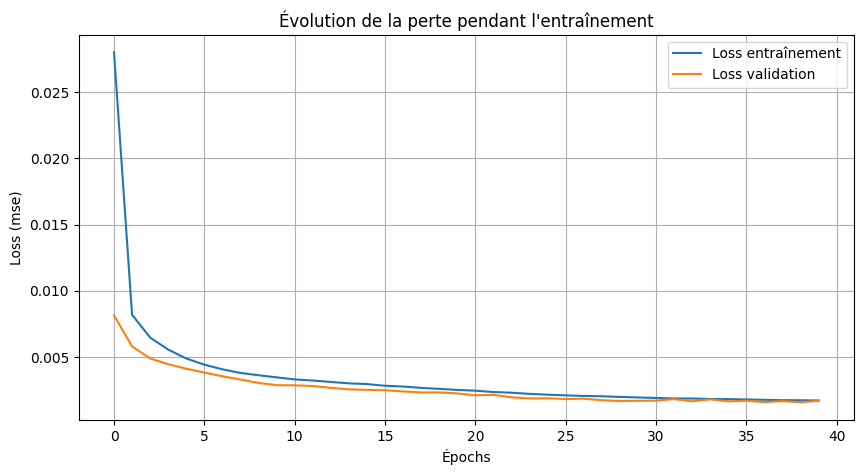

In [186]:

# Affichage de la loss d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.xlabel('Épochs')
plt.ylabel('Loss (mse)')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.grid(True)
plt.show()

241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


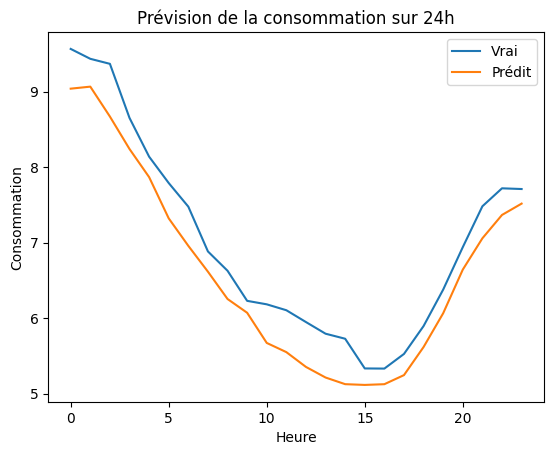

In [187]:


y_pred1 = model1.predict(X_test1)   # Make predictions on the test set

# Si tu veux inverser la normalisation
y_pred_inversed = scalers_minmax['Consommation'].inverse_transform(y_pred1)
y_test_inversed = scalers_minmax['Consommation'].inverse_transform(y_test1)

# Visualisation
plt.plot(y_test_inversed[0], label='Vrai')
plt.plot(y_pred_inversed[0], label='Prédit')
plt.legend()
plt.title("Prévision de la consommation sur 24h")
plt.xlabel("Heure")
plt.ylabel("Consommation")
plt.show()

In [188]:


test_mape = mean_absolute_percentage_error(y_test_inversed, y_pred_inversed) * 100     # Calculate MAPE for the test set for all samples
print(f"Test MAPE: {test_mape:.2f}%")


Test MAPE: 4.53%


In [189]:
# Analyse des résultats obtenus


print("Un MAPE faible (<5%) indique une très bonne précision du modèle. Ici, la valeur obtenue permet d'évaluer la qualité générale des prédictions.")


print("La majorité des échantillons présente une erreur MAPE faible à modérée, mais quelques cas affichent des erreurs plus élevées.")

# 3. Analyse par mois, jour et jour de la semaine
print("Les graphiques précédents montrent que certaines périodes (mois, jours, jours de la semaine) sont associées à des erreurs plus importantes.")
print("Cela peut indiquer une variabilité saisonnière ou des comportements atypiques à certains moments (ex : week-ends, vacances, etc.).")

# 4. Visualisation des meilleures et pires prédictions
print("Les courbes comparant les valeurs réelles et prédites pour les meilleurs et pires échantillons illustrent la capacité du modèle à suivre la tendance générale, mais aussi ses limites lors de variations brusques ou de pics de consommation.")

# 5. Conclusion
print("Globalement, le modèle LSTM fournit de bonnes prévisions pour la majorité des cas. Les erreurs plus élevées sur certains échantillons suggèrent qu'il pourrait être utile d'intégrer d'autres variables explicatives ou d'affiner le prétraitement pour améliorer la robustesse du modèle.")

Un MAPE faible (<5%) indique une très bonne précision du modèle. Ici, la valeur obtenue permet d'évaluer la qualité générale des prédictions.
La majorité des échantillons présente une erreur MAPE faible à modérée, mais quelques cas affichent des erreurs plus élevées.
Les graphiques précédents montrent que certaines périodes (mois, jours, jours de la semaine) sont associées à des erreurs plus importantes.
Cela peut indiquer une variabilité saisonnière ou des comportements atypiques à certains moments (ex : week-ends, vacances, etc.).
Les courbes comparant les valeurs réelles et prédites pour les meilleurs et pires échantillons illustrent la capacité du modèle à suivre la tendance générale, mais aussi ses limites lors de variations brusques ou de pics de consommation.
Globalement, le modèle LSTM fournit de bonnes prévisions pour la majorité des cas. Les erreurs plus élevées sur certains échantillons suggèrent qu'il pourrait être utile d'intégrer d'autres variables explicatives ou d'affin

### @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

suppression de surface_pressure pour voir l'imapct sur les resultats 

In [207]:
df_normalise2 = df_normalise.copy()  # Créer une copie du DataFrame pour la normalisation
df_normalise2.drop(columns=["surface_pressure"], inplace=True)  # Drop the 'surface_pressure' column 

In [208]:
import numpy as np

sequence_length = 24  # Nombre de pas de temps dans chaque séquence
forecast_horizon = 24 # Nombre de pas de temps à prédire

def create_sequences(data, target_col, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):
        X.append(data.iloc[i:i+sequence_length].values)
        y.append(data.iloc[i+sequence_length:i+sequence_length+forecast_horizon][target_col].values)
    return np.array(X), np.array(y)


target_col = "Consommation"

In [209]:
X, y = create_sequences(df_normalise2, target_col, sequence_length, forecast_horizon)  # Create sequences for the entire dataset

In [210]:
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [211]:
X_test_indices = [i for i in range(len(df_normalise2) - sequence_length - forecast_horizon)][-len(X_test):]

In [212]:
model = Sequential([
    LSTM(64,  return_sequences=True, dropout=0.1, recurrent_dropout=0.1, input_shape=(sequence_length, X.shape[2])),  # 1re couche LSTM
    LSTM(32, dropout=0.1, recurrent_dropout=0.1,  return_sequences=False),  # 2e couche LSTM
    
    Dense(forecast_horizon, activation='linear')  # 24 sorties pour les 24 heures futures
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[MeanAbsolutePercentageError()])


model.summary()

c:\Users\emac\OneDrive - IMT Mines Albi\Projet stage\Eneenergy-forecasting-1\project_venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 24, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,408 (126.59 KB)

 Trainable params: 32,408 (126.59 KB)

 Non-trainable params: 0 (0.00 B)

In [213]:
history = model.fit(X_train, y_train, epochs=40, batch_size=30,  validation_data=(X_test, y_test),
verbose=1)

Epoch 1/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 25s 21ms/step - loss: 0.0589 - mean_absolute_percentage_error: 64.4959 - val_loss: 0.0077 - val_mean_absolute_percentage_error: 14969.2100
Epoch 2/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.0085 - mean_absolute_percentage_error: 30.7651 - val_loss: 0.0057 - val_mean_absolute_percentage_error: 13160.2734
Epoch 3/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0068 - mean_absolute_percentage_error: 26.7683 - val_loss: 0.0051 - val_mean_absolute_percentage_error: 12923.7275
Epoch 4/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0058 - mean_absolute_percentage_error: 24.6210 - val_loss: 0.0045 - val_mean_absolute_percentage_error: 11266.8418
Epoch 5/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.0051 - mean_absolute_percentage_error: 22.8176 - val_loss: 0.0039 - val_mean_absolute_percentage_error: 10310.9111
Epoch 6/40
1025/1025 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0047 - mean_absolute_percenta

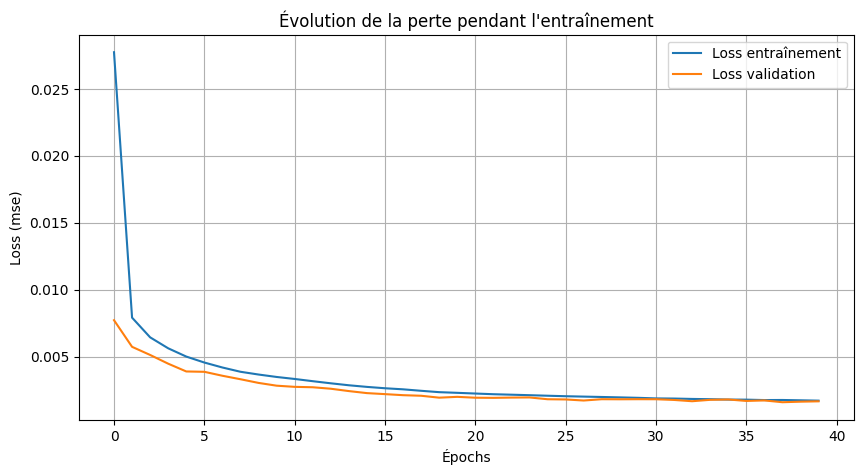

In [214]:
# Affichage de la loss d'entraînement et de validation
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Loss entraînement')
plt.plot(history.history['val_loss'], label='Loss validation')
plt.xlabel('Épochs')
plt.ylabel('Loss (mse)')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.grid(True)
plt.show()

241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


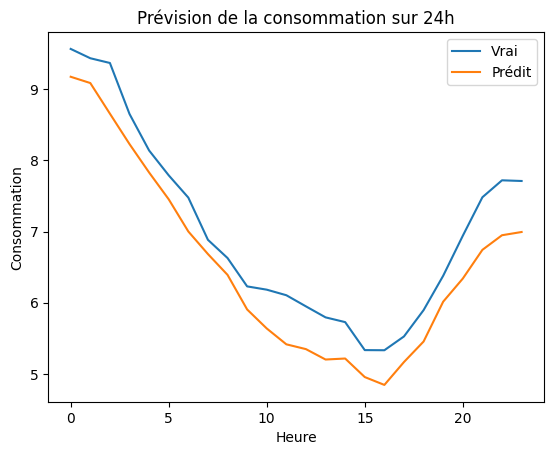

In [215]:

y_pred = model.predict(X_test)

#  inverser la normalisation
y_pred_inversed = scalers_minmax['Consommation'].inverse_transform(y_pred)
y_test_inversed = scalers_minmax['Consommation'].inverse_transform(y_test)

# Visualisation
plt.plot(y_test_inversed[0], label='Vrai')
plt.plot(y_pred_inversed[0], label='Prédit')
plt.legend()
plt.title("Prévision de la consommation sur 24h")
plt.xlabel("Heure")
plt.ylabel("Consommation")
plt.show()

In [216]:
from sklearn.metrics import mean_absolute_percentage_error

test_mape = mean_absolute_percentage_error(y_test_inversed, y_pred_inversed) * 100
print(f"Test MAPE: {test_mape:.2f}%")

Test MAPE: 4.54%


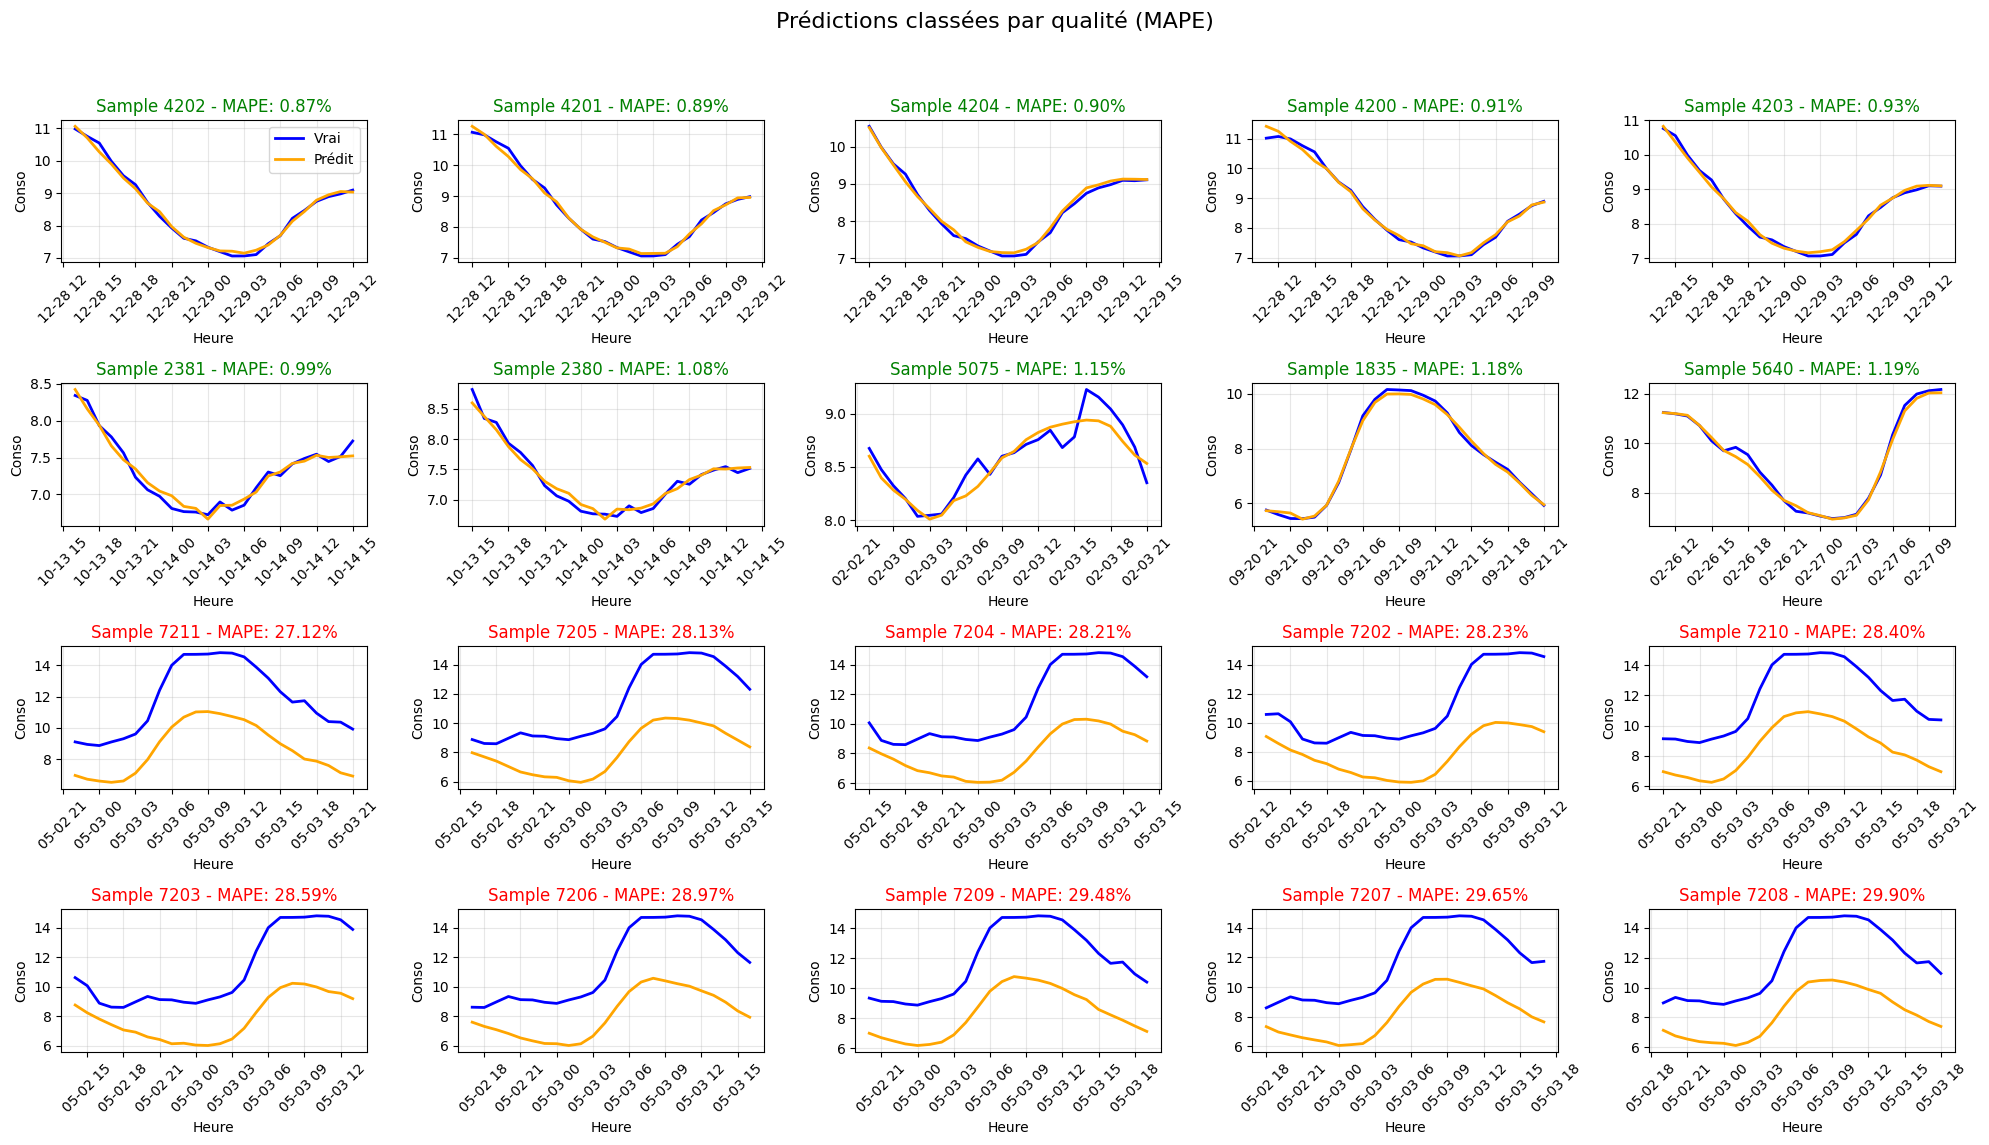

In [217]:



def safe_mape(y_true, y_pred):
    """MAPE qui évite la division par zéro"""
    mask = y_true != 0
    if mask.sum() == 0:
        return 0
    return mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100

# Vérifications
assert len(y_test_inversed) == len(y_pred_inversed)

# Calcul MAPE
mape_scores = [safe_mape(y_test_inversed[i], y_pred_inversed[i]) for i in range(len(y_test_inversed))]
sorted_indices = np.argsort(mape_scores)

# Sélection des échantillons
n_samples = min(10, len(y_test_inversed) // 2)    # Nombre d'échantillons à afficher (10 ou la moitié de l'ensemble de test) minimum of the two
best_indices = sorted_indices[:n_samples]   # Indices des meilleurs échantillons
worst_indices = sorted_indices[-n_samples:]          # Indices des pires échantillons
indices_to_plot = np.concatenate([best_indices, worst_indices])   # Combine best and worst indices for plotting

# Timestamps
try:
    timestamps = df_normalise.index[sequence_length + forecast_horizon:]
    timestamps_test = timestamps[X_test_indices]
    use_timestamps = True
except:
    print("Utilisation d'indices simples pour les timestamps")
    use_timestamps = False

# Visualisation
n_plots = len(indices_to_plot)       # Total number of plots to display
n_cols = 5
n_rows = (n_plots + n_cols - 1) // n_cols    # Calculate number of rows needed for the plots

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
fig.suptitle("Prédictions classées par qualité (MAPE)", fontsize=16)

# S'assurer que axes est un array 2D
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, idx in enumerate(indices_to_plot):
    row, col = divmod(i, n_cols)
    ax = axes[row, col]
    
    # Axe X
    if use_timestamps:
        start_time = timestamps_test[idx]
        hours = [start_time + pd.Timedelta(hours=h) for h in range(forecast_horizon)]
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue', linewidth=2)
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange', linewidth=2)
        ax.tick_params(axis='x', rotation=45)
    else:
        hours = range(forecast_horizon)
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue', linewidth=2)
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange', linewidth=2)
    
    # Titres et labels
    color = 'green' if i < n_samples else 'red'  # Vert pour les meilleurs, rouge pour les pires
    ax.set_title(f"Sample {idx} - MAPE: {mape_scores[idx]:.2f}%", color=color)
    ax.set_xlabel("Heure")
    ax.set_ylabel("Conso")
    ax.grid(True, alpha=0.3)
    
    # Légende seulement sur le premier graphique
    if i == 0:
        ax.legend()

# Masquer les subplots vides
for i in range(n_plots, n_rows * n_cols):
    row, col = divmod(i, n_cols)
    axes[row, col].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

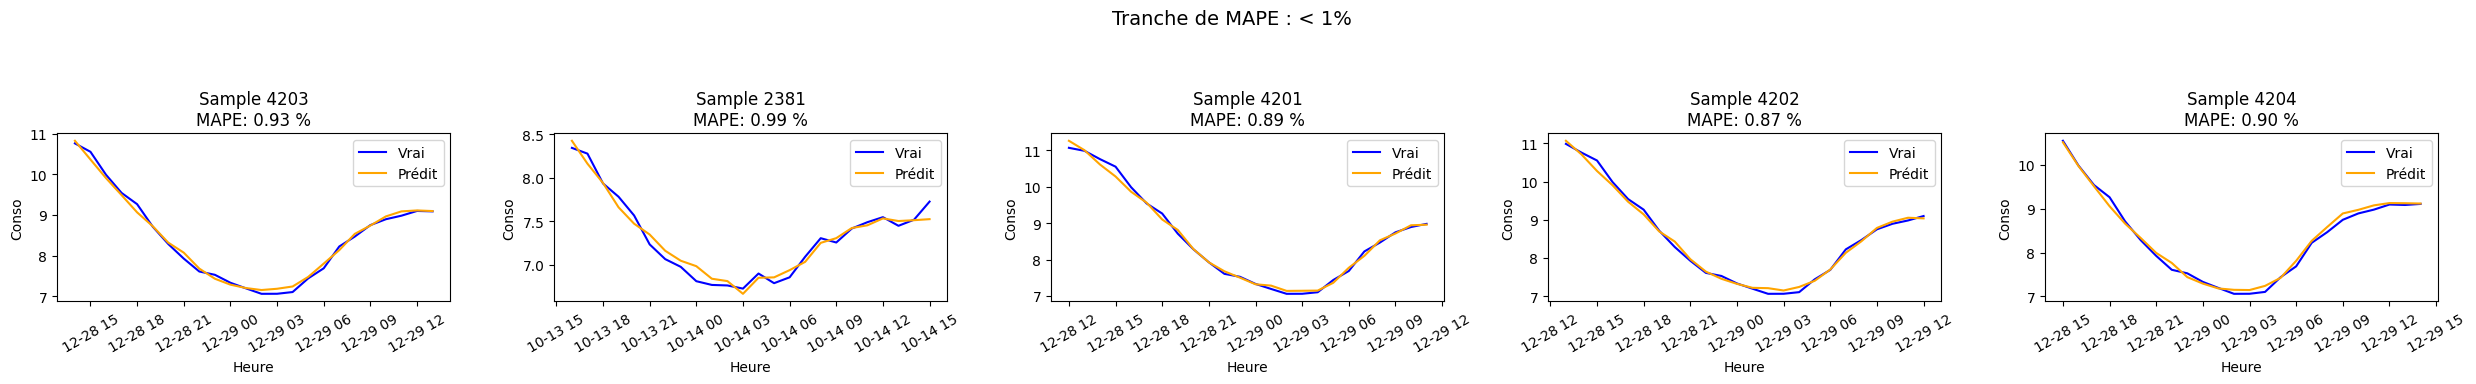

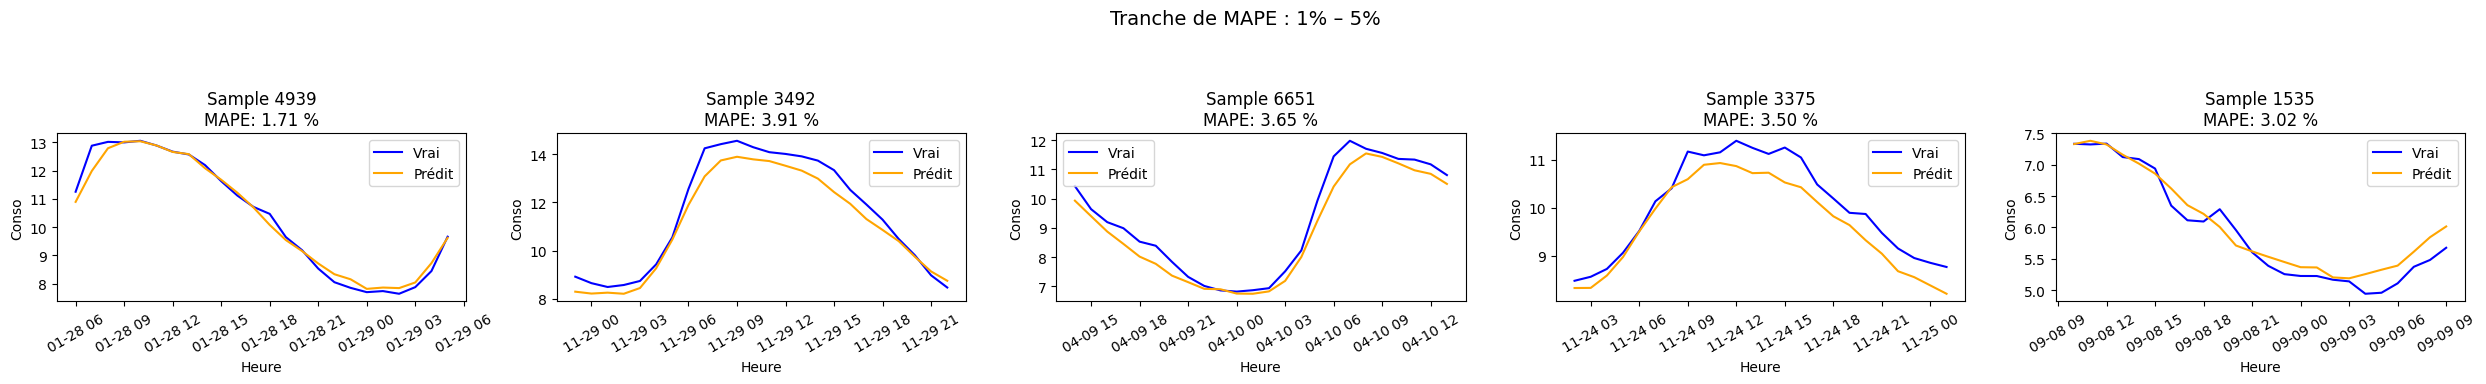

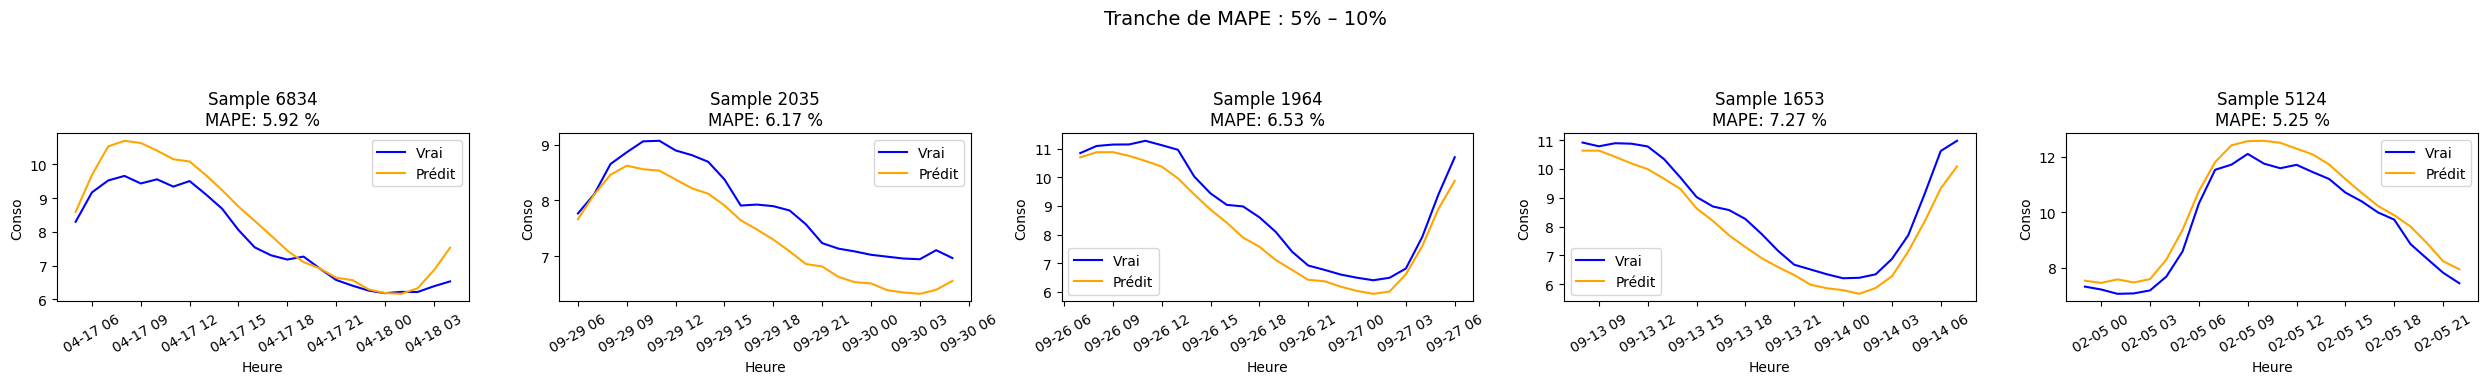

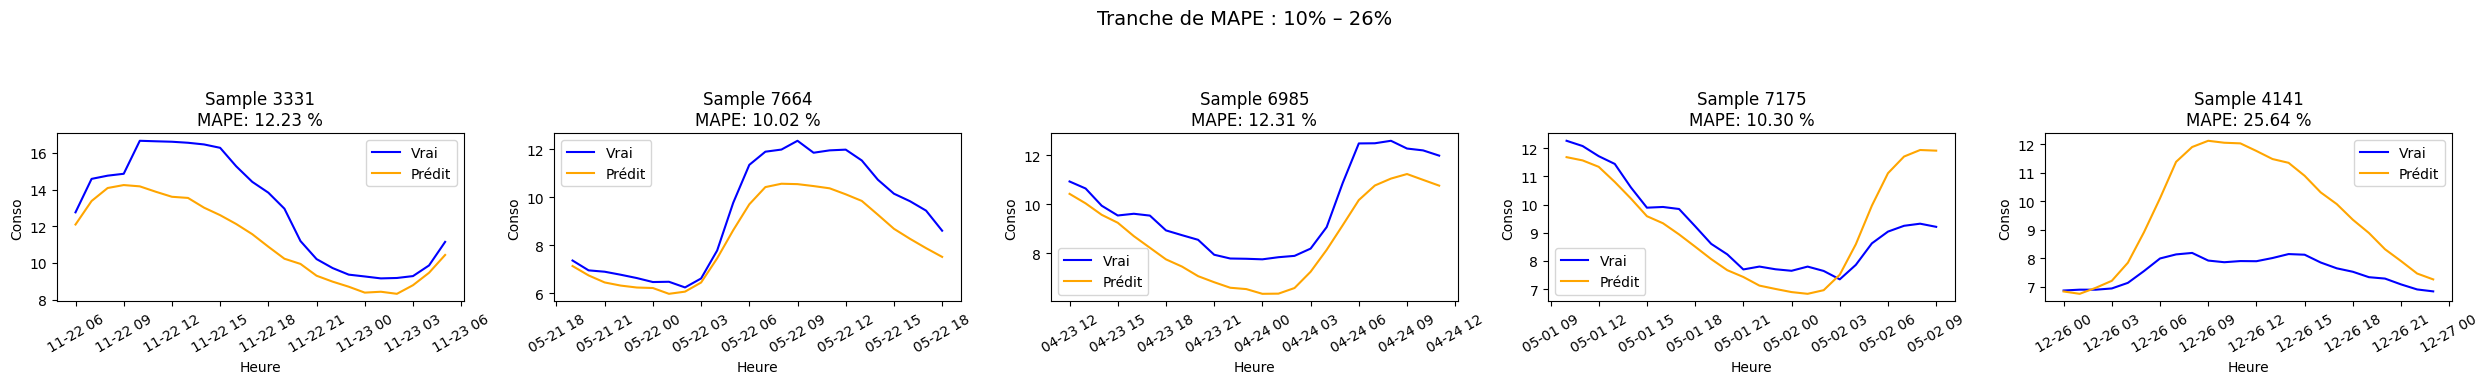

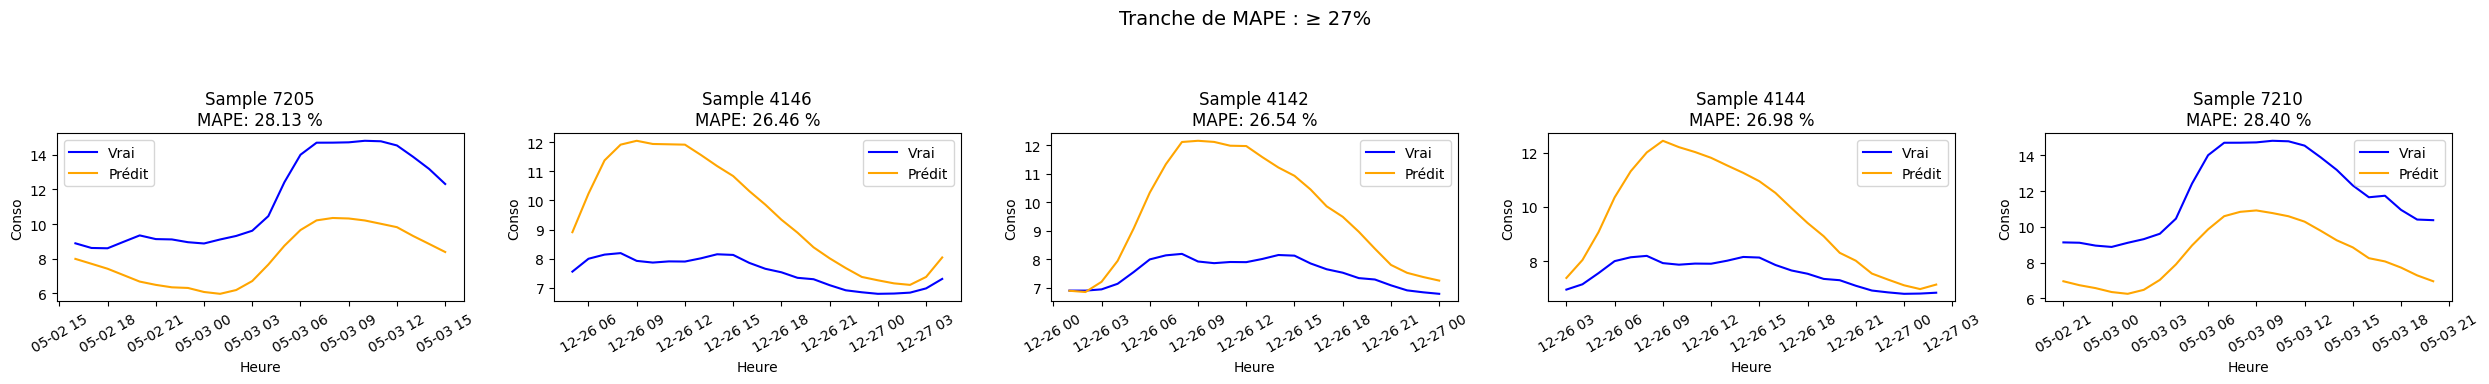

In [218]:

# Calcul des MAPE
mape_scores = [mean_absolute_percentage_error(y_test_inversed[i], y_pred_inversed[i]) * 100 for i in range(len(y_test_inversed))]
 
# Tranches de MAPE
mape_bins = {
    "< 1%": [],  # Tranche pour MAPE < 1%
    "1% – 5%": [],     
    "5% – 10%": [],
    "10% – 26%": [],
    "≥ 27%": []
}
 
# Répartition des indices dans chaque tranche
for i, mape in enumerate(mape_scores):
    if mape < 1:
        mape_bins["< 1%"].append(i)    # Tranche pour MAPE < 1%
    elif mape < 5:
        mape_bins["1% – 5%"].append(i)
    elif mape < 10 :
        mape_bins["5% – 10%"].append(i)
    elif mape < 26 :
        mape_bins["10% – 26%"].append(i)
    else:
        mape_bins["≥ 27%"].append(i)
 
# Timestamps
try:
    timestamps = df_normalise.index[sequence_length + forecast_horizon:]
    timestamps_test = timestamps[X_test_indices]
    use_timestamps = True
except:
    print("Utilisation d'indices simples pour les timestamps")
    use_timestamps = False
 
# Affichage : 5 graphes par tranche
for category, indices in mape_bins.items():
    if len(indices) == 0:
        print(f"Aucun échantillon pour la tranche '{category}'")   # Skip if no samples in this category
        continue
 
    sample_indices = random.sample(indices, min(5, len(indices)))   # Sélection aléatoire de 5 échantillons ou moins si moins d'échantillons disponibles
 
    fig, axes = plt.subplots(1, len(sample_indices), figsize=(5 * len(sample_indices), 4))      # Create subplots for each sample
    fig.suptitle(f"Tranche de MAPE : {category}", fontsize=14)       # Title for the entire figure
 
    # S'assurer que axes est itérable
    if len(sample_indices) == 1:
        axes = [axes]
 
    for ax, idx in zip(axes, sample_indices):
        start_time = timestamps_test[idx]
        hours = [start_time + pd.Timedelta(hours=h) for h in range(forecast_horizon)]   # Generate hours for the x-axis
 
        ax.plot(hours, y_test_inversed[idx], label='Vrai', color='blue')
        ax.plot(hours, y_pred_inversed[idx], label='Prédit', color='orange')
        ax.set_title(f"Sample {idx}\nMAPE: {mape_scores[idx]:.2f} %")
        ax.set_xlabel("Heure")
        ax.set_ylabel("Conso")
        ax.xaxis.set_tick_params(rotation=30)
 
        ax.legend()
 
    plt.tight_layout(rect=[0, 0.03, 1, 0.90])
    plt.show()

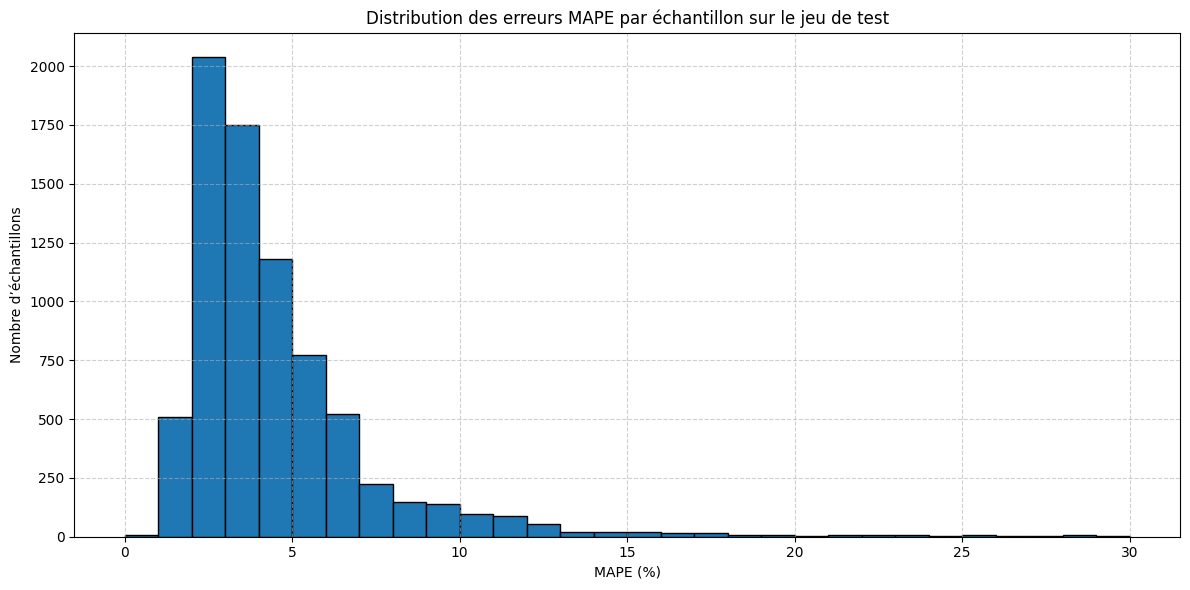

In [219]:

# Calcul du MAPE par échantillon
# Ici, on calcule le MAPE pour chaque échantillon et chaque horizon de prédiction
# puis on fait la moyenne sur l'horizon pour obtenir un score par échantillon
mape_per_sample = np.mean(np.abs((y_test_inversed - y_pred_inversed) / (y_test_inversed + 1e-8)) * 100, axis=1)

#  Regroupement des MAPE en intervalles (bins)
bins = np.arange(0, np.ceil(mape_per_sample.max()) +1 , 1)

# Tracer l’histogramme
plt.figure(figsize=(12, 6))
plt.hist(mape_per_sample, bins=bins, edgecolor='black')
plt.xlabel("MAPE (%)")
plt.ylabel("Nombre d’échantillons")
plt.title("Distribution des erreurs MAPE par échantillon sur le jeu de test")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [220]:
dates_test = df_business_consumption.loc[X_test_indices, "Date"]     # Get the dates corresponding to the test set indices

C:\Users\emac\AppData\Local\Temp\ipykernel_6620\3364321957.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


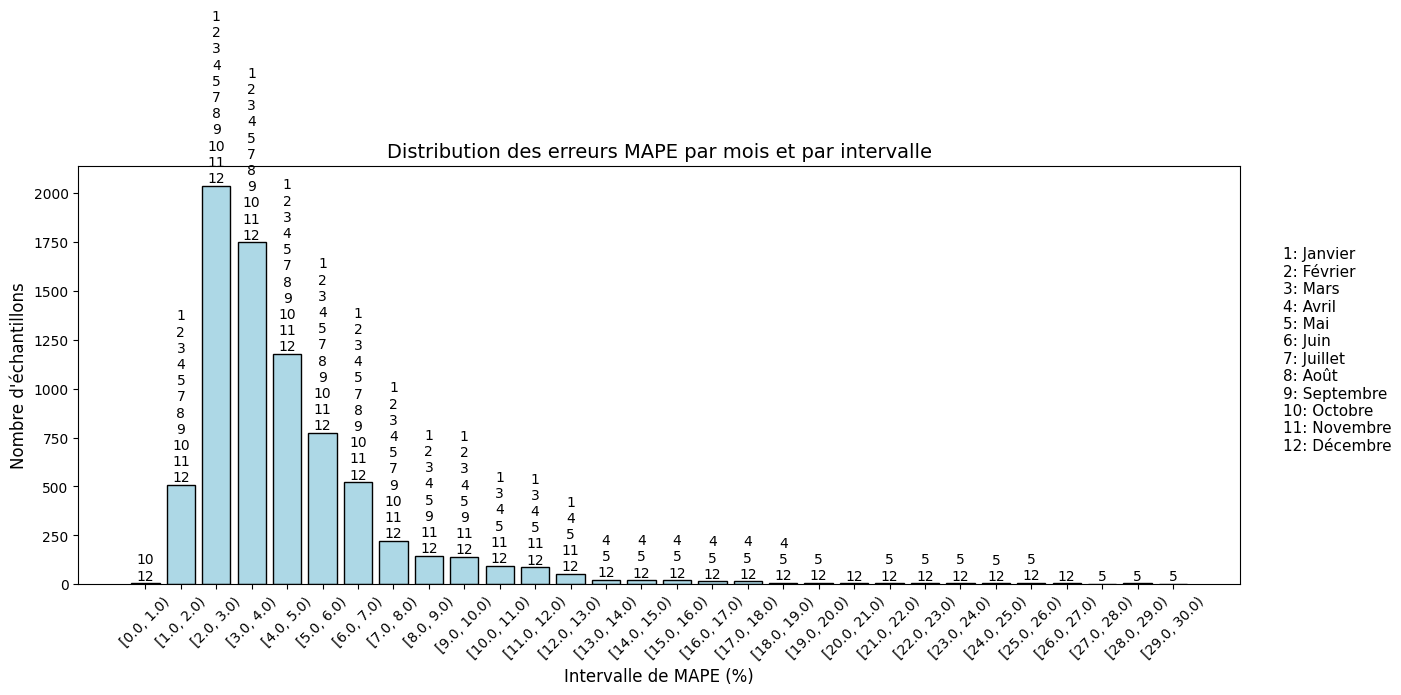

In [221]:
# Convertir timestamps en datetime si ce n'est pas déjà fait
timestamps_test = pd.to_datetime(timestamps_test)

#  Pour chaque timestamp, extraire tous les mois couverts par l'horizon de 24h
mois_par_sample = []
for t in timestamps_test:
    # Générer la série horaire pour l'horizon
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    # Extraire les mois uniques
    mois = dates_horizon.month.unique()
    mois_par_sample.append(mois)

#  Créer les intervalles de MAPE (par exemple 1%)
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

#  Construire DataFrame
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Mois": mois_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

#  Grouper par bin pour compter les échantillons
df_grouped = df.groupby("MAPE_bin").size()

#  Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

#  Ajouter tous les mois (aplatir les listes) au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    mois_listes = df.loc[df["MAPE_bin"] == bin_label, "Mois"]
    # Aplatir les listes et extraire les mois uniques
    tous_les_mois = sorted(set(m for sous_liste in mois_listes for m in sous_liste))
    mois_str = "\n".join(str(m) for m in tous_les_mois)
    ax.text(i, df_grouped.values[i] + 1, mois_str, ha='center', va='bottom', fontsize=10, color='black')

#  Mise en forme
ax.set_title("Distribution des erreurs MAPE par mois et par intervalle", fontsize=14)
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

# Légende mois à droite
mois_legende = "\n".join([
    "1: Janvier", "2: Février", "3: Mars", "4: Avril",
    "5: Mai", "6: Juin", "7: Juillet", "8: Août",
    "9: Septembre", "10: Octobre", "11: Novembre", "12: Décembre"
])
plt.gcf().text(0.92, 0.5, mois_legende, fontsize=11, va='center')

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

C:\Users\emac\AppData\Local\Temp\ipykernel_6620\2631605013.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


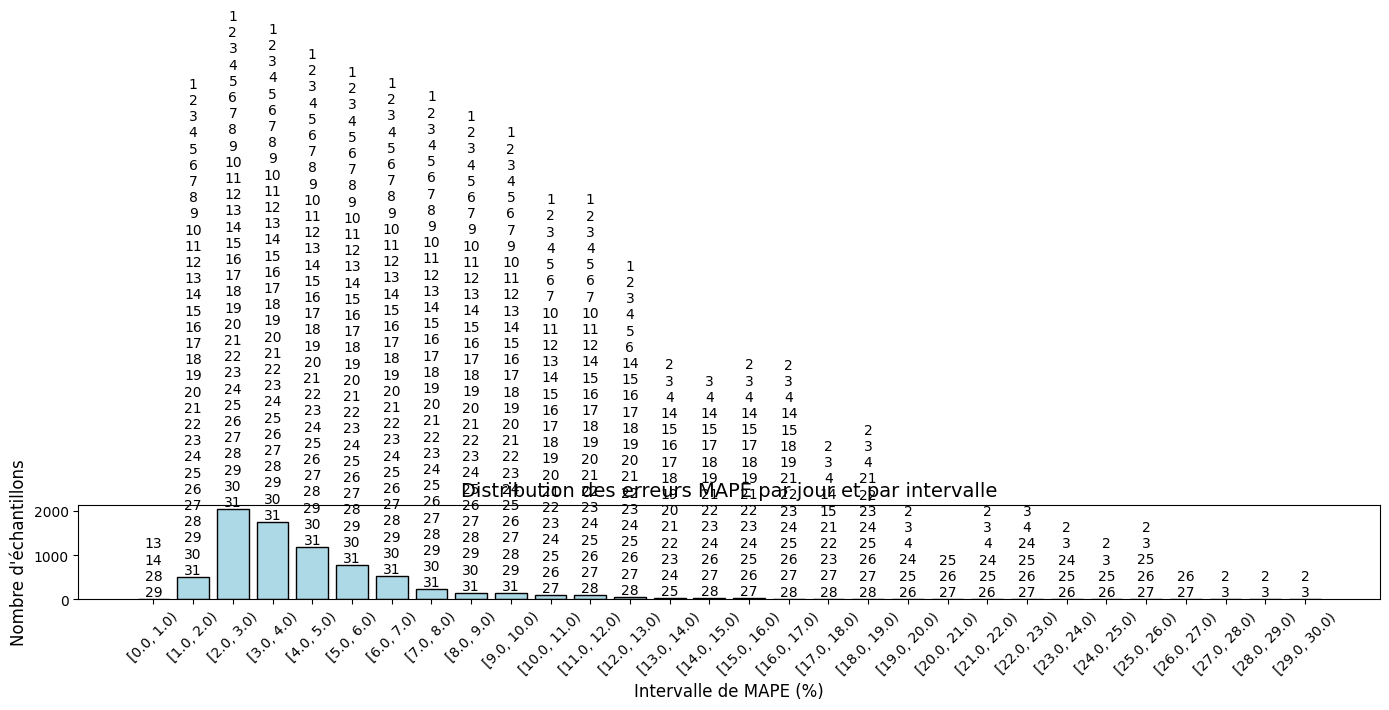

In [222]:


timestamps_test = pd.to_datetime(timestamps_test)

# Extraire tous les jours (numéro du jour dans le mois) couverts par chaque horizon
jours_par_sample = []
for t in timestamps_test:
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    jours = dates_horizon.day.unique()  # jours dans le mois
    jours_par_sample.append(jours)

# Intervalles de MAPE (ajuste selon ton max MAPE)
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

# DataFrame avec MAPE et jours multiples
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Jours": jours_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

# Compter les échantillons par intervalle
df_grouped = df.groupby("MAPE_bin").size()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

# Ajouter les jours uniques au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    jours_listes = df.loc[df["MAPE_bin"] == bin_label, "Jours"]
    tous_les_jours = sorted(set(j for sous_liste in jours_listes for j in sous_liste))
    jours_str = "\n".join(str(j) for j in tous_les_jours)
    ax.text(i, df_grouped.values[i] + 1, jours_str, ha='center', va='bottom', fontsize=10, color='black')

# Mise en forme
ax.set_title("Distribution des erreurs MAPE par jour et par intervalle", fontsize=14)
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


C:\Users\emac\AppData\Local\Temp\ipykernel_6620\2188255723.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby("MAPE_bin").size()


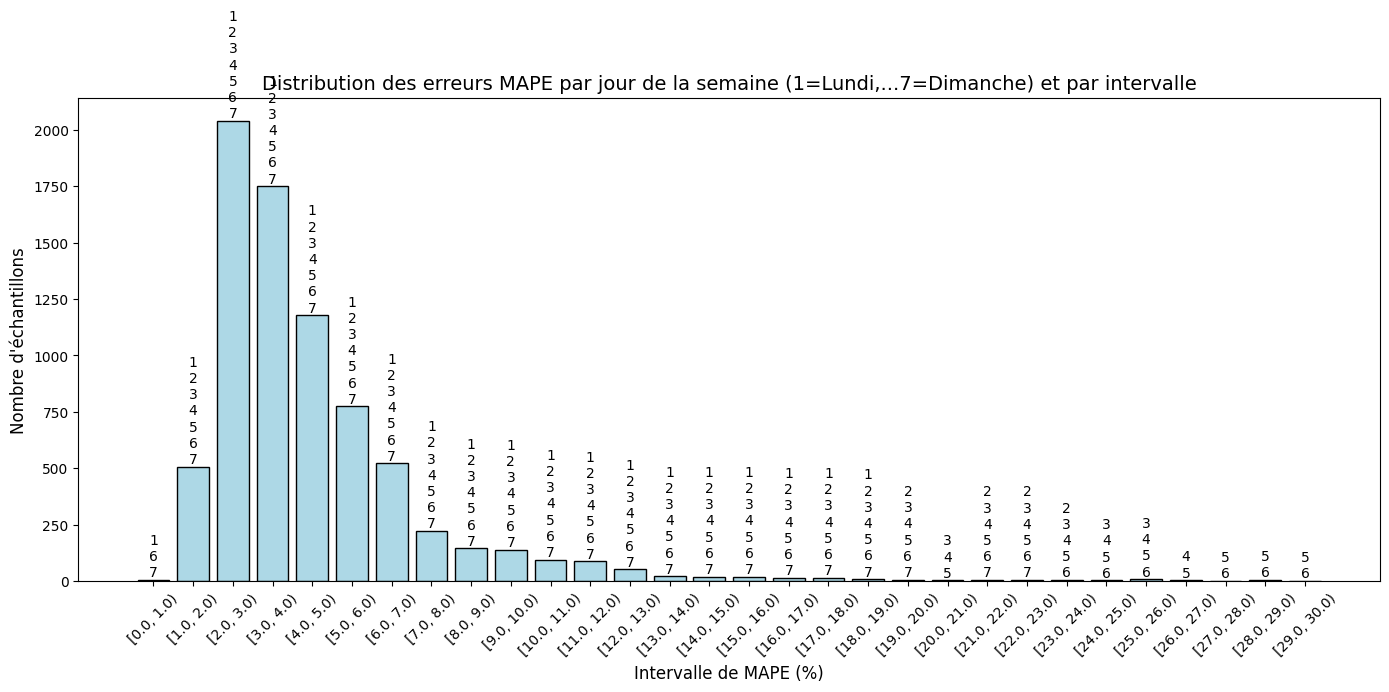

In [223]:


timestamps_test = pd.to_datetime(timestamps_test)    # Convertir les timestamps en datetime si ce n'est pas déjà fait

# Extraire les jours de la semaine couverts par chaque horizon (1=Lundi ... 7=Dimanche)
jours_sem_par_sample = []
for t in timestamps_test:
    dates_horizon = pd.date_range(start=t, periods=forecast_horizon, freq='h')
    jours_idx = dates_horizon.dayofweek.unique()  # 0=Lundi ... 6=Dimanche
    # Convertir en 1-7
    jours_chiffres = [j + 1 for j in jours_idx]
    jours_sem_par_sample.append(jours_chiffres)

# Intervalles de MAPE
bins = np.arange(0, np.ceil(mape_per_sample.max()) + 1, 1)

# DataFrame avec MAPE et jours de la semaine multiples
df = pd.DataFrame({
    "MAPE": mape_per_sample,
    "Jours_semaine": jours_sem_par_sample
})
df["MAPE_bin"] = pd.cut(df["MAPE"], bins=bins, right=False)

# Compter les échantillons par intervalle
df_grouped = df.groupby("MAPE_bin").size()

# Plot
fig, ax = plt.subplots(figsize=(14, 7))
bars = ax.bar(df_grouped.index.astype(str), df_grouped.values, edgecolor='black', color='lightblue')

# Ajouter les jours de la semaine uniques (chiffres) au-dessus des barres
for i, bin_label in enumerate(df_grouped.index):
    jours_listes = df.loc[df["MAPE_bin"] == bin_label, "Jours_semaine"]
    tous_les_jours = sorted(set(j for sous_liste in jours_listes for j in sous_liste))
    jours_str = "\n".join(str(j) for j in tous_les_jours)
    ax.text(i, df_grouped.values[i] + 1, jours_str, ha='center', va='bottom', fontsize=10, color='black')

# Mise en forme
ax.set_title("Distribution des erreurs MAPE par jour de la semaine (1=Lundi,...7=Dimanche) et par intervalle", fontsize=14)  
ax.set_xlabel("Intervalle de MAPE (%)", fontsize=12)
ax.set_ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
